**Building Scalar Autograd - An automatic Differentiation Library**

Inspired from Andrej Karpathy: [Karpathy's micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

***Intuition of Derivatives***

In [2]:
def f(x):
    return 3*x**2-4*x+5

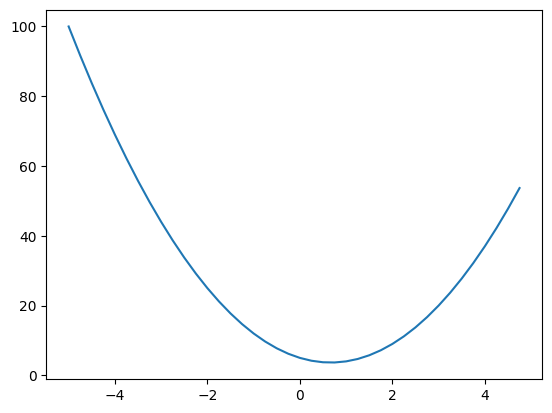

In [3]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [4]:
### Getting the derivative is simple computing the value below

x=-3.0
h=0.0000001
print((f(x+h)-f(x))/h)

x=3.0
h=0.0000001
print((f(x+h)-f(x))/h)

-21.999999688659955
14.000000305713911


**Data Structure for storing the values and performing required operations**

In [5]:
### For Neural Networks the expressions for finding the derivatives is massive, so we need some kind of a datastructure for this

# Python Magic methods are the methods starting and ending with double underscores ‘__’. They are defined by built-in classes in Python and commonly used for operator overloading.

# They are also called Dunder methods, Dunder here means “Double Under (Underscores)”.

class Value:

    def __init__(self, data, _children = (), _op = "", label = ""):

        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):

        return f"Value(data={self.data})"

    def __add__(self, other):

        output = Value(self.data + other.data, (self, other), '+')
        return output

    def __sub__(self, other):

        output = Value(self.data-other.data, (self, other), '-')
        return output

    def __mul__(self, other):

        output = Value(self.data*other.data, (self, other), "*")
        return output

    def __div__(self, other):

        output = Value(self.data/other.data, (self, other), "/")
        return output



a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
d = Value(10.0, label = "d")
c = a*b
c.label = "c"
e = d+c
e.label = "e"
e

Value(data=4.0)

In [6]:
e._prev

{Value(data=-6.0), Value(data=10.0)}

**Utility function for Visualization**

In [7]:
### Function to visulalize the Neural Network

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):

    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f  }" % (n.label, n.data), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
    # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

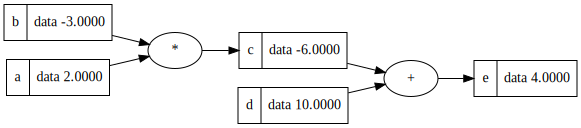

In [8]:
draw_dot(e)

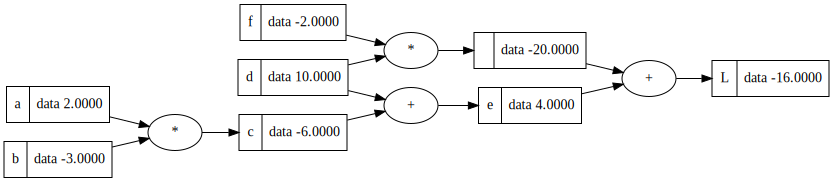

In [9]:
a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
d = Value(10.0, label = "d")
c = a*b
c.label = "c"
e = d+c
e.label = "e"
f = Value(-2.0, label = "f")
L = d*f+e
L.label = "L"
draw_dot(L)

**Running Backpropagation and storing Gradient values**

In [10]:
### For Neural Networks the expressions for finding the derivatives is massive, so we need some kind of a datastructure for this

# Python Magic methods are the methods starting and ending with double underscores ‘__’. They are defined by built-in classes in Python and commonly used for operator overloading.

# They are also called Dunder methods, Dunder here means “Double Under (Underscores)”.

class Value:

    def __init__(self, data, _children = (), _op = "", label = ""):

        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0

    def __repr__(self):

        return f"Value(data={self.data})"

    def __add__(self, other):

        output = Value(self.data + other.data, (self, other), '+')
        return output

    def __sub__(self, other):

        output = Value(self.data-other.data, (self, other), '-')
        return output

    def __mul__(self, other):

        output = Value(self.data*other.data, (self, other), "*")
        return output

    def __div__(self, other):

        output = Value(self.data/other.data, (self, other), "/")
        return output

    def tanh(self):

      x = self.data
      tanh_x = (math.exp(2*x)-1)/(math.exp(2*x)+1)
      return Value(tanh_x, (self, ), 'tanh')



a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
d = Value(10.0, label = "d")
c = a*b
c.label = "c"
e = d+c
e.label = "e"
e

Value(data=4.0)

**Modified Utility function for showing grads**

In [11]:
### Function to visulalize the Neural Network

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):

    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
    # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

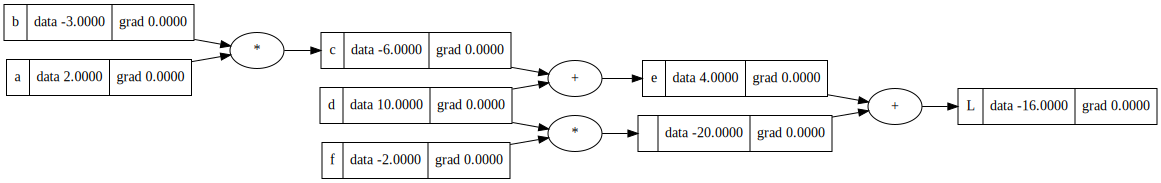

In [12]:
a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
d = Value(10.0, label = "d")
c = a*b
c.label = "c"
e = d+c
e.label = "e"
f = Value(-2.0, label = "f")
L = d*f+e
L.label = "L"
draw_dot(L)

**Activation Function**

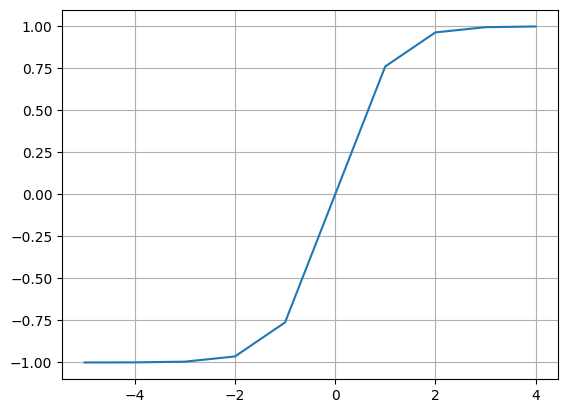

In [13]:
## Tanh Activation Function
plt.plot(np.arange(-5,5,1), np.tanh(np.arange(-5,5,1)))
plt.grid()

**Mimicing an actual Neuron**

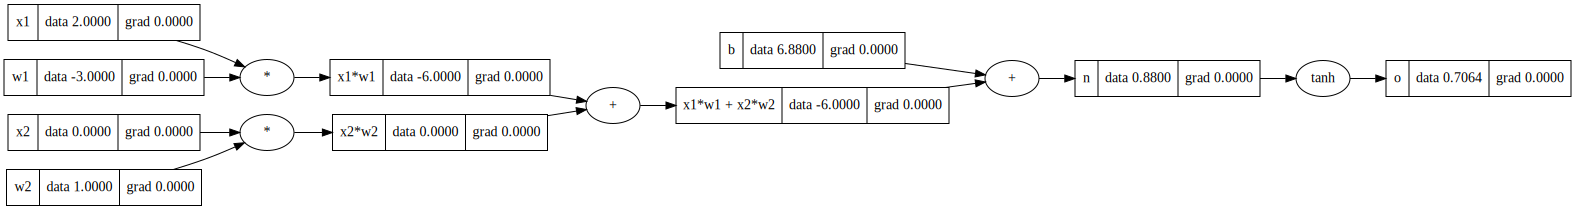

In [14]:
## Input Values
x1 = Value(data = 2.0, label = "x1")
x2 = Value(data = 0.0, label = "x2")

## Weight Values
w1 = Value(data = -3.0, label = "w1")
w2 = Value(data = 1.0, label = "w2")

## Bias value
b = Value(data = 6.88, label = "b")

## Computing x1w1+x2w2+b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2+b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)


**Manually doing the Backpropagation, we just need the Local gradient value - Chain Rule**


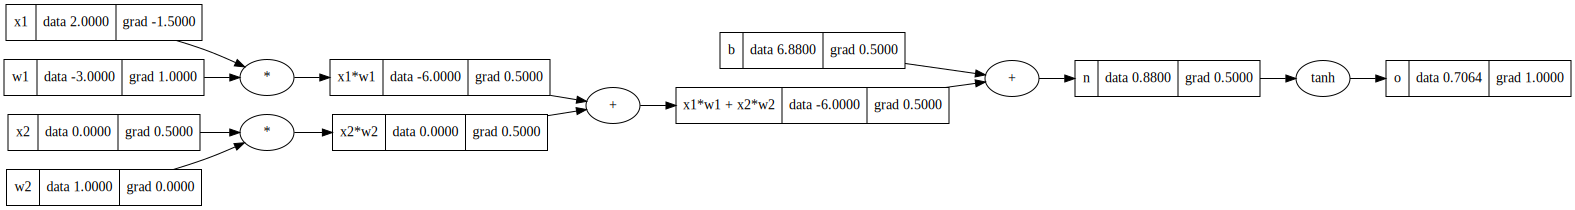

In [15]:
o.grad = 1.0
n.grad = 0.5 ## d(tanh(x))/dx = 1-tanh(x)**2
b.grad = 0.5 ## do/db = do/dn * dn/db = 0.5*1 = 0.5(Chain Rule)
x1w1x2w2.grad = 0.5
x1w1.grad , x2w2.grad = 0.5, 0.5
x1.grad = -1.5 ## w1.data*x1w1.grad = -3*0.5
w1.grad = 1.0
x2.grad = 0.5
w2.grad = 0.0

draw_dot(o)

**Modifying the Value Class: Doing the BackPropagation Automatically**

In [16]:
### For Neural Networks the expressions for finding the derivatives is massive, so we need some kind of a datastructure for this

# Python Magic methods are the methods starting and ending with double underscores ‘__’. They are defined by built-in classes in Python and commonly used for operator overloading.

# They are also called Dunder methods, Dunder here means “Double Under (Underscores)”.

class Value:

    def __init__(self, data, _children = (), _op = "", label = ""):

        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):

        return f"Value(data={self.data})"

    def __add__(self, other):

        output = Value(self.data + other.data, (self, other), '+')

        ## Backpropagation value in case of addition operation
        def _backward():
          self.grad = output.grad
          other.grad = output.grad

        output._backward = _backward

        return output

    def __sub__(self, other):

        output = Value(self.data-other.data, (self, other), '-')

        ## Backpropagation value in case of subtraction operation
        def _backward():
          self.grad = output.grad
          other.grad = -1.0*output.grad

        output._backward = _backward
        return output

    def __mul__(self, other):

        output = Value(self.data*other.data, (self, other), "*")

        ## Backpropagation value in case of multiplication operation
        def _backward():
          self.grad = other.data*output.grad
          other.grad = self.data*output.grad

        output._backward = _backward
        return output

    def __div__(self, other):

        output = Value(self.data/other.data, (self, other), "/")

        ## Backpropagation value in case of division operation
        def _backward():
          self.grad = (1/other.data)*output.grad
          other.grad = -1.0*self.data*(1/other.data**2)*output.grad

        output._backward = _backward
        return output

    def tanh(self):

      x = self.data
      tanh_x = (math.exp(2*x)-1)/(math.exp(2*x)+1)

      t = Value(tanh_x, (self, ), 'tanh')

      ## Backpropagation value in case of Activation Function operation
      def _backward():
        self.grad = (t.grad)*(1-tanh_x**2)

      t._backward = _backward
      return t



In [17]:
## Input Values
x1 = Value(data = 2.0, label = "x1")
x2 = Value(data = 0.0, label = "x2")

## Weight Values
w1 = Value(data = -3.0, label = "w1")
w2 = Value(data = 1.0, label = "w2")

## Bias value
b = Value(data = 6.88, label = "b")

## Computing x1w1+x2w2+b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2+b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [18]:
o.grad = 1.0 ## Intializing the grad to its actual value
o._backward() ##Updates the gradient value of n - Visible when we draw

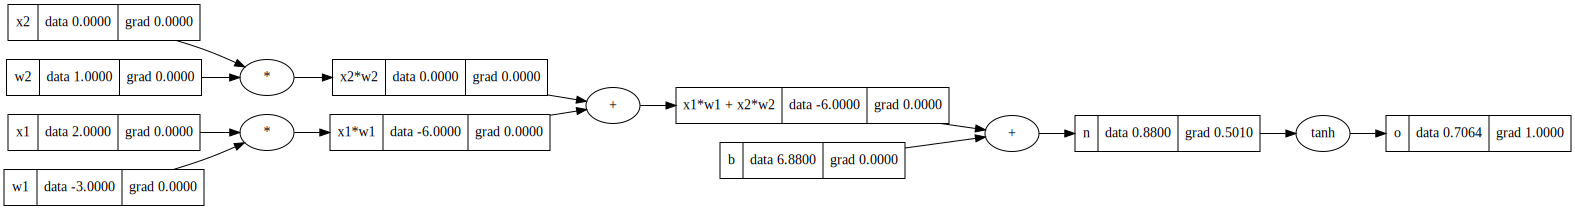

In [19]:
draw_dot(o)

In [20]:
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
x2._backward()
w1._backward()
w2._backward()

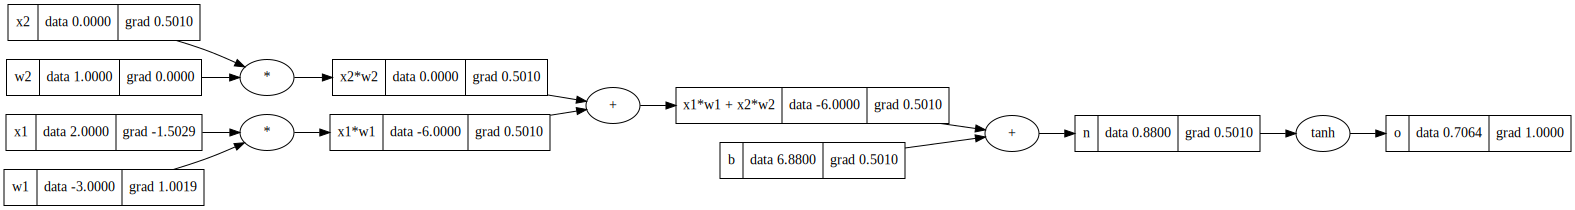

In [21]:
draw_dot(o)



*   We achieved back propagation
*   However we don't want to call the _backward function on individual nodes independently


*   Looking carefully we see that for calculating the gradient of a node, we need the gradient of all nodes preceeding that node.
*   We can find such an ordering using Topological sort





**Modifying Value Class to do Backpropagation without the need of invoking individual function calls**

In [22]:
### For Neural Networks the expressions for finding the derivatives is massive, so we need some kind of a datastructure for this

# Python Magic methods are the methods starting and ending with double underscores ‘__’. They are defined by built-in classes in Python and commonly used for operator overloading.

# They are also called Dunder methods, Dunder here means “Double Under (Underscores)”.

class Value:

    def __init__(self, data, _children = (), _op = "", label = ""):

        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):

        return f"Value(data={self.data})"

    def __add__(self, other):

        output = Value(self.data + other.data, (self, other), '+')

        ## Backpropagation value in case of addition operation
        def _backward():
          self.grad = output.grad
          other.grad = output.grad

        output._backward = _backward

        return output

    def __sub__(self, other):

        output = Value(self.data-other.data, (self, other), '-')

        ## Backpropagation value in case of subtraction operation
        def _backward():
          self.grad = output.grad
          other.grad = -1.0*output.grad

        output._backward = _backward
        return output

    def __mul__(self, other):

        output = Value(self.data*other.data, (self, other), "*")

        ## Backpropagation value in case of multiplication operation
        def _backward():
          self.grad = other.data*output.grad
          other.grad = self.data*output.grad

        output._backward = _backward
        return output

    ## This is needed to support operations like 2*a
    ## If python does not know how to multiply 2*a, it invokes __rmul__ to check if a*2 can be done

    def __rmul__(self, other):
      return self*other

    def __div__(self, other):

        output = Value(self.data/other.data, (self, other), "/")

        ## Backpropagation value in case of division operation
        def _backward():
          self.grad = (1/other.data)*output.grad
          other.grad = -1.0*self.data*(1/other.data**2)*output.grad

        output._backward = _backward
        return output


    def tanh(self):

      x = self.data
      tanh_x = (math.exp(2*x)-1)/(math.exp(2*x)+1)

      t = Value(tanh_x, (self, ), 'tanh')

      ## Backpropagation value in case of Activation Function operation
      def _backward():
        self.grad = (t.grad)*(1-tanh_x**2)

      t._backward = _backward
      return t

    def backward(self):

      topo, visited = [], set()

      # Topological sort to get the order of the backpropagation
      def build_topo(v):

        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()






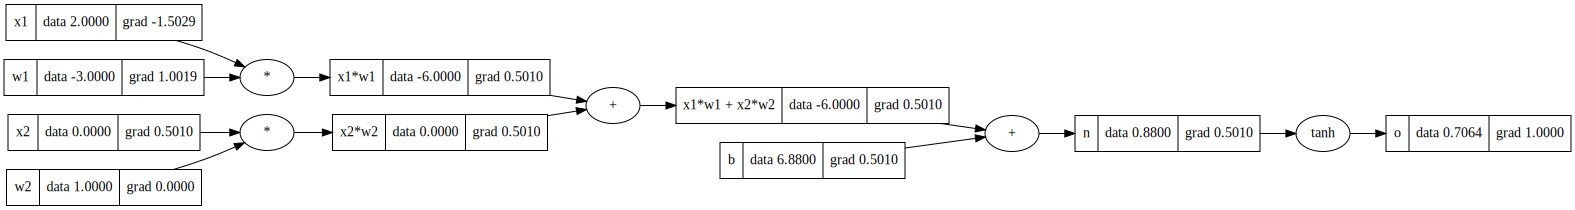

In [23]:
## Input Values
x1 = Value(data = 2.0, label = "x1")
x2 = Value(data = 0.0, label = "x2")

## Weight Values
w1 = Value(data = -3.0, label = "w1")
w2 = Value(data = 1.0, label = "w2")

## Bias value
b = Value(data = 6.88, label = "b")

## Computing x1w1+x2w2+b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2+b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

**Bug in our code**

Code does not work here because self and other point to the same object a

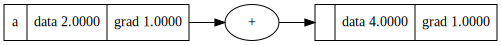

In [24]:
a = Value(2.0, label = "a")
b = a+a
b.backward()
draw_dot(b)


Code does not work in the case below because there are multiple dependencies of a and b. For example the grad value of a depends on the grad value of d and e both. For Multiple dependencies we just need to add the contributrions (Multivariate Version of Chain Rule)


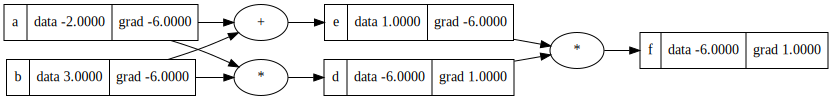

In [25]:
a = Value(-2.0, label = "a")
b = Value(3.0, label = "b")
d = a*b; d.label = "d"
e = a+b; e.label = "e"
f = d*e; f.label = "f"

f.backward()
draw_dot(f)


Solution: Instead of setting the grad values add the contributions

**Rectifying Bug in our code**


*   Rectifying the backpropagation bug in our code
*   Modifying the magic functions such that operations like Value ob. + 1 are supported


*   Supporting operations like exponential





In [26]:
### For Neural Networks the expressions for finding the derivatives is massive, so we need some kind of a datastructure for this

# Python Magic methods are the methods starting and ending with double underscores ‘__’. They are defined by built-in classes in Python and commonly used for operator overloading.

# They are also called Dunder methods, Dunder here means “Double Under (Underscores)”.

class Value:

    def __init__(self, data, _children = (), _op = "", label = ""):

        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):

        return f"Value(data={self.data})"

    def __add__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data + other.data, (self, other), '+')

        ## Backpropagation value in case of addition operation
        def _backward():
          self.grad += output.grad
          other.grad += output.grad

        output._backward = _backward

        return output

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data-other.data, (self, other), '-')

        ## Backpropagation value in case of subtraction operation
        def _backward():
          self.grad += output.grad
          other.grad += -1.0*output.grad

        output._backward = _backward
        return output

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __neg__(self):

      return self*-1

    def __mul__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data*other.data, (self, other), "*")

        ## Backpropagation value in case of multiplication operation
        def _backward():
          self.grad += other.data*output.grad
          other.grad += self.data*output.grad

        output._backward = _backward
        return output

    def __div__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        output = Value(self.data/other.data, (self, other), "/")

        ## Backpropagation value in case of division operation
        def _backward():
          self.grad += (1/other.data)*output.grad
          other.grad += -1.0*self.data*(1/other.data**2)*output.grad

        output._backward = _backward
        return output

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        output = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * output.grad

        output._backward = _backward
        return output

    def exp(self):

      x = self.data
      exp = math.exp(x)

      t = Value(exp, (self, ), 'exp')

      ## Backpropagation value in case of Activation Function operation
      def _backward():
        self.grad += (t.grad)*exp

      t._backward = _backward
      return t


    def tanh(self):

      x = self.data
      tanh_x = (math.exp(2*x)-1)/(math.exp(2*x)+1)

      t = Value(tanh_x, (self, ), 'tanh')

      ## Backpropagation value in case of Activation Function operation
      def _backward():
        self.grad += (t.grad)*(1-tanh_x**2)

      t._backward = _backward
      return t

    def relu(self):

      x = self.data
      t = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

      ## Backpropagation value in case of Activation Function operation
      def _backward():
        self.grad += (self.data < 0)*t.grad

      t._backward = _backward
      return t

    def backward(self):

      topo, visited = [], set()

      # Topological sort to get the order of the backpropagation
      def build_topo(v):

        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()


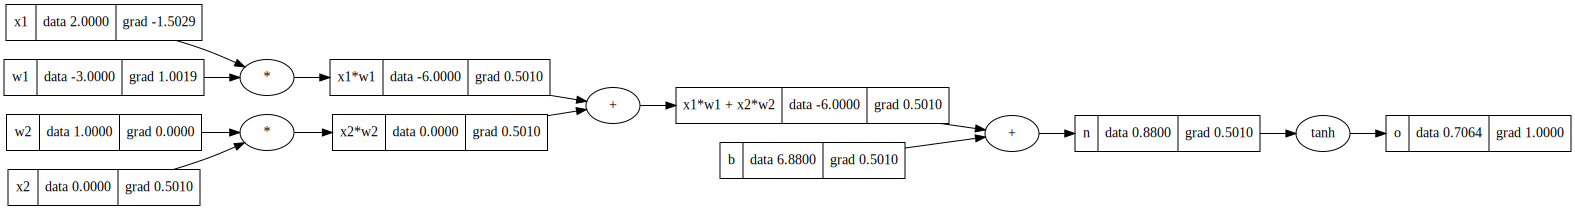

In [27]:
## Input Values
x1 = Value(data = 2.0, label = "x1")
x2 = Value(data = 0.0, label = "x2")

## Weight Values
w1 = Value(data = -3.0, label = "w1")
w2 = Value(data = 1.0, label = "w2")

## Bias value
b = Value(data = 6.88, label = "b")

## Computing x1w1+x2w2+b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2+b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

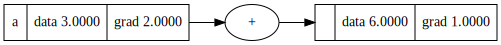

In [28]:
a = Value(3.0, label = 'a')
b = a+a
b.backward()
draw_dot(b)

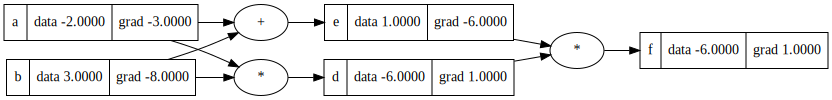

In [29]:
a = Value(-2.0, label = "a")
b = Value(3.0, label = "b")
d = a*b; d.label = "d"
e = a+b; e.label = "e"
f = d*e; f.label = "f"

f.backward()
draw_dot(f)


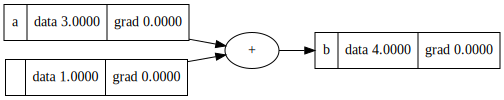

In [30]:
a = Value(3.0, label = 'a')
b = a+1; b.label = 'b'
draw_dot(b)

**Doing similar things using Pytorch**

In [31]:
import torch

## Input Values : Typecasted to double to match the python default of double precision - float64, Default setting of Pytorch is float32
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

## Weight Values
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

## Bias value
b = torch.Tensor([6.88]).double() ; b.requires_grad = True

## Computing x1w1+x2w2+b

n = x1*w1 + x2*w2 + b # You cannot write n.requires_grad = True, because in pytorch you can only change requires_grad flags of leaf variables.
o = torch.tanh(n)


o.backward()

In [32]:
print(o.data.item())
print(x1.grad.item())
print(x2.grad.item())
print(w1.grad.item())
print(w2.grad.item())

0.7064193777288968
-1.5029149883073547
0.5009716627691182
1.0019433255382364
0.0


**Moving from a single Neuron to a MLP**

In [33]:
class Module:

  def parameters(self):

    return []

  def zero_grad(self):

    for p in self.parameters():
      p.grad = 0.0

class Neuron(Module):

  def __init__(self, n_inp, nonlin = True):
    self.w = [Value(random.uniform(-1,1)) for _ in range(n_inp)]
    self.b = Value(0)
    self.nonlin = nonlin

  def __call__(self, x):

    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    return act.relu() if self.nonlin else act

  def parameters(self):

    return self.w + [self.b]

  def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"


class Layer(Module):

  def __init__(self, n_inp, n_out, **kwargs):

    self.neurons = [Neuron(n_inp, **kwargs) for _ in range(n_out)]

  def __call__(self, x):

    out = [neuron(x) for neuron in self.neurons]
    return out[0] if len(out)==1 else out

  def parameters(self):

    return [params for neuron in self.neurons for params in neuron.parameters()]

  def __repr__(self):

    return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"





In [34]:
x = [2.0,3.0]
n = Layer(2,3)

In [35]:
## Each neuron expects two sources of data inputs, so two weights associated with each neuron
print(n.neurons[0].b)
print(n.neurons[0].w)

Value(data=0)
[Value(data=-0.12553572864858276), Value(data=0.012944562688079975)]


***Introducing the MLP Class***

In [87]:
class Module:

  def parameters(self):

    return []

  def zero_grad(self):

    for p in self.parameters():
      p.grad = 0.0

class Neuron(Module):

  def __init__(self, n_inp : int, nonlin : bool = True, label = ""):
    self.w = [Value(random.uniform(-1,1), label = label if label else f"w_{i}" ) for i in range(n_inp)]
    self.b = Value(0, label = "b")
    self.nonlin = nonlin

  def __call__(self, x, activation = 'tanh'):

    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    act.label = "Activation"
    return act.tanh() if activation == 'tanh' else act.relu()

  def parameters(self):

    return self.w + [self.b]

  def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"


class Layer(Module):

  def __init__(self, n_inp : int, n_out : int, **kwargs):

    self.neurons = [Neuron(n_inp, **kwargs) for _ in range(n_out)]

  def __call__(self, x):

    out = [neuron(x) for neuron in self.neurons]
    return out[0] if len(out)==1 else out

  def parameters(self):

    return [params for neuron in self.neurons for params in neuron.parameters()]

  def __repr__(self):

    return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

  def __init__(self, n_inp : int, n_outs : list, **kargs):

    layer_sz = [n_inp]+n_outs
    self.layers = [Layer(layer_sz[i], layer_sz[i+1], label = f"Layer_{i}") for i in range(len(layer_sz)-1)]

  def __call__(self, x):

    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
        return [params for layer in self.layers for params in layer.parameters()]

  def __repr__(self):
      return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [88]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.29796279743330034)

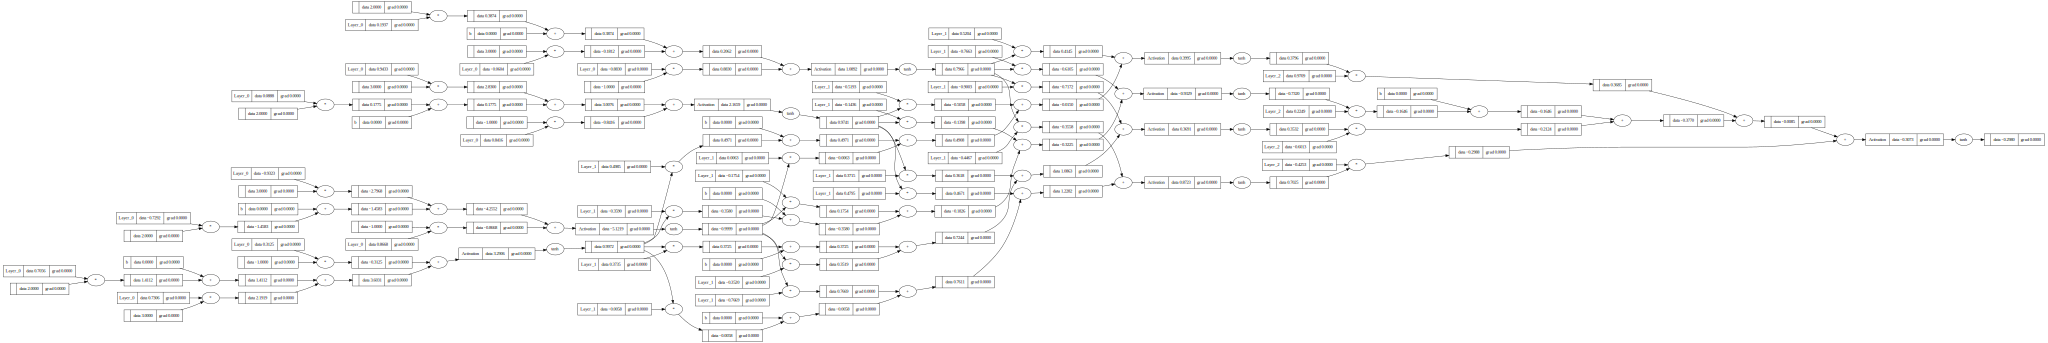

In [89]:
draw_dot(n(x))

**Trying to train our small MLP on dummy data**

In [90]:
## Dummy data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

## MLP
n = MLP(3, [4,4,1])

In [91]:
print(f'Number of parameters in the neural net : {len(n.parameters())}')

Number of parameters in the neural net : 41


In [92]:
epochs =  100
for epoch in range(epochs):

  y_pred = [n(x) for x in xs]
  loss = sum(((y_out-y_gt)**2 for y_out, y_gt in zip(y_pred, ys)))

  # Zero grad before the backpropagation
  n.zero_grad()
  loss.backward()

  # Gradient Descent: The direction of the gradient is the direction in which the loss increases, so we need to go the opposite direction
  for p in n.parameters():
    p.data += -0.05*p.grad



In [93]:
y_pred

[Value(data=0.9641840087400454),
 Value(data=-0.979648334551939),
 Value(data=-0.9474499779612445),
 Value(data=0.9585884446874519)]